In [27]:
from time import process_time
import matplotlib.pyplot as plt
import scipy
import psutil
import time

from qutip import *
from qutip.piqs import *

import scipy.integrate as integrate
from scipy.integrate import quad

import numpy as np
from numpy import linalg as LA
from IPython.display import display, clear_output

# Common parameters

In [28]:
def gauss(x, x_0, sigma):
    return 1*np.exp(-((x-x_0) / sigma) ** 2)

def ind_op(op1, op2, N_spin, index):
    # create a tensor product of op1 everywhere but at index, where it's op2
    # returns tensor_i!=index op1 tensor op2
    a = [op1] * N_spin
    a[index] = op2
    return tensor(a)

def sum_ops(op1, op2, N_spin, c):
    # sum of all permutations where all operators are op1 but one is op2
    return sum([c*ind_op(op1, op2, N_spin, i) for i in range(N_spin)])

In [29]:
# Model description
# Units in kHz
# /2pi

gk = 1.6 # kHz Coupling strength
kappa = 160. # kHz Cavity linewidth
gamma = 2000. #
Gamma = 0. # Dephasing

N_spin = 1e2 # Total number of emitters
N_cav = 30 # Fock states
k = 1 # Number of frequency classes
delta_c = 0. # wc-wp
sigma_c = 10.*kappa # Broadening STD

Delta_max = 5.*sigma_c
# delta_a = np.linspace(-Delta_max, Delta_max, k) # Spin inhomogenous broadening span
delta_a = 0.001*sigma_c
norm = np.sum(gauss(delta_a, 0, sigma_c))
ki = gauss(delta_a, delta_c, sigma_c)/norm*N_spin # Population distribution for each class 

# Square pulse
dt = 1/5*1/N_spin # Take into consideration of the fastest oscillation in the system
endtime = 4./gk
intervals = int(endtime/dt)
tlist = np.linspace(0, endtime, intervals)
tprep = 0.2 #us*endtime
F = 1 #kHz
Ft = F*np.append(np.ones(int(intervals*tprep)), np.zeros(int(intervals*(1-tprep))))
# Ft = np.zeros(intervals)

w_spin = delta_a - 1j*(gamma/2. + Gamma)
w_cav = delta_c - 1j*kappa/2.
print('Intervals = ', intervals)

Intervals =  1250


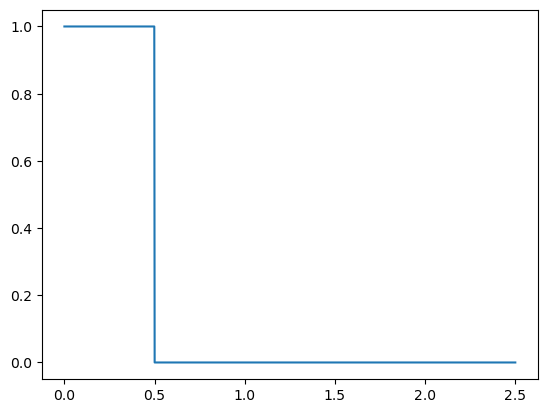

In [4]:
plt.plot(tlist, Ft)

# QuTiP

## Exact Solver

In [52]:
class exact_sys:
    
    def __init__(self, N_spin, N_cav, E_spin=True):
        # N_spin: number of spins
        # N_cav: the dimension of the Fock space, assume 0 excitation in the cavity
        # E_spin: bool, whether the spins are initially excited
        self.N_spin = N_spin
        self.N_cav = N_cav
        self.E_spin = E_spin
        self.ID_spin = tensor([qeye(2)]*N_spin)
        # Initial sate
        if E_spin:
            self.psi0 = tensor(basis(N_cav, 0), tensor([basis(2, 0)]*N_spin))
        else:
            self.psi0 =  psi0 = tensor(basis(N_cav, 0), tensor([basis(2, 1)]*N_spin))
        # Operators
        self.a = tensor(destroy(N_cav), self.ID_spin)
        self.ad = tensor(destroy(N_cav).dag(),self.ID_spin)
        self.sp = tensor(qeye(N_cav), sum_ops(qeye(2), sigmap(), N_spin, 1))
        self.sm = tensor(qeye(N_cav), sum_ops(qeye(2), sigmam(), N_spin, 1))
        self.sz = tensor(qeye(N_cav), sum_ops(qeye(2), sigmaz(), N_spin, 1))
        
        # Hamiltonian
        H0 = delta_c*self.ad*self.a + delta_a/2*self.sz + gk*(self.a*self.sp + self.ad*self.sm)
        self.H = [H0, [(self.ad+self.a), Ft]] 
    
    def __str__(self):
        return f'Exact solver for {self.N_spin} spins, Fock states = {self.N_cav}'
    
    def run_mesolve(self, tlist, c_ops, e_ops):
        start = time.time()
        out = mesolve(self.H, self.psi0, tlist, c_ops = c_ops, e_ops = e_ops)
        end = time.time()
        print(f'Run time: {end-start}s')
        return out

In [75]:
# Example use
exact = exact_sys(4, 20)
exact_out = exact.run_mesolve(tlist, [np.sqrt(kappa/10)*exact.a], [exact.sz, exact.ad*exact.a])

Run time: 24.232027053833008s


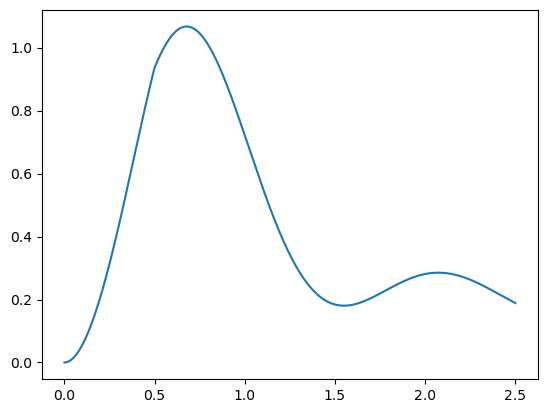

In [64]:
plt.plot(tlist, exact_out.expect[1])

## Permutational-invariant PIQS

In [65]:
class piqs_sys:
    def __init__(self, N_spin, N_cav, E_spin=True):
        self.N_spin = N_spin
        self.N_cav = N_cav
        self.E_spin = E_spin
        self.ID_spin = to_super(qeye(self.N_spin))
        self.ID_cav = to_super(qeye(self.N_cav))

        # Operators
        self.a = tensor(destroy(N_cav), self.ID_spin)
        self.ad = tensor(destroy(N_cav).dag(),self.ID_spin)
        self.sp = tensor(qeye(N_cav), sum_ops(qeye(2), sigmap(), N_spin, 1))
        self.sm = tensor(qeye(N_cav), sum_ops(qeye(2), sigmam(), N_spin, 1))
        self.sz = tensor(qeye(N_cav), sum_ops(qeye(2), sigmaz(), N_spin, 1))
        
        # Two-level operators
        nds = num_dicke_states(N_spin)
        [jx, jy, jz] = jspin(N_spin)
        jz = 2*jz
        jp, jm = jspin(N_spin, "+"), jspin(N_spin, "-")
        
        # Cavity operators
        a = destroy(N_cav)
        
        # System superoperators
        self.jz_tot = tensor(qeye(N_cav), jz)
        self.jm_tot = tensor(qeye(N_cav), jm)
        self.jp_tot = tensor(qeye(N_cav), jp)
        self.jpjm_tot = tensor(qeye(N_cav), jp*jm)
        self.a_tot = tensor(a, qeye(nds))
        self.ada_tot = tensor(a.dag()*a, qeye(nds))
        if self.E_spin:
            self.psi0 = tensor(fock_dm(N_cav,0), excited(N_spin, basis='dicke'))
        else:
            self.psi0 = tensor(fock_dm(N_cav,0), ground(N_spin, basis='dicke'))
        # Hamiltonian
        H_spin = delta_a/2 * self.jz_tot
        H_cav = delta_c * self.a_tot.dag() * self.a_tot
        H_int = gk * (self.a_tot.dag()*self.jm_tot + self.a_tot*self.jm_tot.dag())
        self.H = [H_spin+H_cav+H_int, [(self.a_tot.dag()+self.a_tot), Ft]] 
        
    def __str__(self):
        if self.E_spin:
            return f'PIQS solver for {self.N_spin} excited spins, Fock states = {self.N_cav}'
        else:
            return f'PIQS solver for {self.N_spin} ground state spins, Fock states = {self.N_cav}'
    
    def run_mesolve(self, tlist, c_ops, e_ops):
        start = time.time()
        out = mesolve(self.H, self.psi0, tlist, c_ops = c_ops, e_ops = e_ops)
        end = time.time()
        print(f'Run time: {end-start}s')
        return out

Run time: 351.2518491744995s


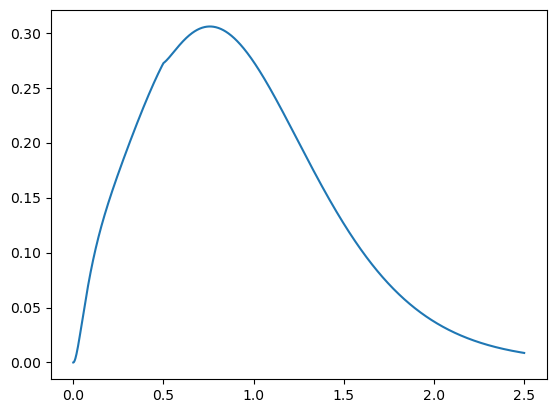

In [232]:
piq = piqs_sys(12,20)
piq_out = piq.run_mesolve(tlist, [np.sqrt(kappa/5)*piq.a_tot], [piq.jz_tot,piq.ada_tot])
plt.plot(tlist, piq_out.expect[1])

## Plot comparison with the exact solver

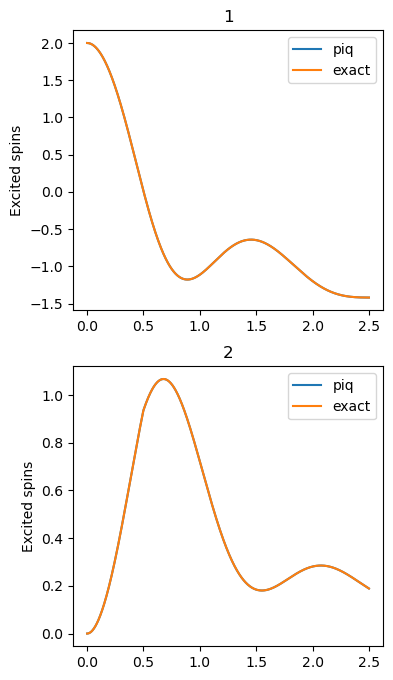

In [70]:
fig, ax = plt.subplots(2,1, figsize=(4,8))
for i in range(2):    
    ax[i].plot(tlist, piq_out.expect[i], label = 'piq')
    ax[i].plot(tlist, exact_out.expect[i], label = 'exact')
    ax[i].legend()
    ax[i].set_ylabel('Excited spins')
    ax[i].set_title(i+1)

In [ ]:
%%time
psi0_1 = tensor(basis(N_cav,0), basis(2,0))
a_1 = tensor(destroy(N_cav), qeye(2))
ad_1 = a_1.dag()
sp_1 = tensor(qeye(N_cav), sigmap())
sm_1 = sp_1.dag()
sz_1 = tensor(qeye(N_cav), sigmaz())
H0_1 = delta_c*ad_1*a_1 + delta_a/2.*sz_1 + gk*(a_1*sp_1 + ad_1*sm_1)
out1 = mesolve(H0_1, psi0_1, tlist, e_ops=[(sz+1)/2.])

CPU times: user 3.07 s, sys: 35.9 ms, total: 3.11 s
Wall time: 3.11 s


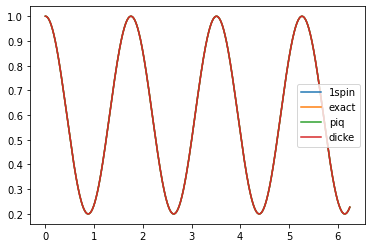

In [ ]:
plt.plot(tlist, out1.expect[0], label='1spin')
plt.plot(tlist, n_ex[0], label='exact')
plt.plot(tlist, n_ex_piq[0], label='piq')
plt.plot(tlist, out_p.expect[0], label='dicke')
plt.legend()

# Mean-field solver

Text(0, 0.5, 'Population')

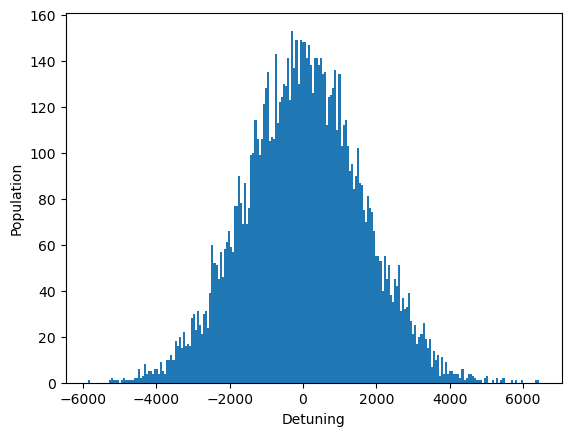

In [5]:
from numpy.random import seed
from numpy.random import normal

#make this example reproducible
seed(1)

data = normal(loc=delta_c, scale=10*kappa, size=10**4)
class_pop, detuning, ignored = plt.hist(data, 220)
plt.xlabel('Detuning')
plt.ylabel('Population')

## Mean-field equations (different classes)

In [130]:
class mean_field_sys:
    
    def __init__(self, N_cav, delta_c, gk, gamma, Gamma, kappa, F, end, dt, N_class, detuning, E_spin=True, Int_2nd=False, sci=True):
        self.k = len(N_class)
        self.N_class = N_class # Distirbution of spins in each class, k-D array
        self.N_cav = N_cav
        self.delta_c = delta_c
        self.delta_a = detuning + delta_c 
        self.gamma = gamma
        self.Gamma = Gamma
        self.kappa = kappa
        self.w_spin = self.delta_a - 1j*(self.gamma/2. + self.Gamma)
        self.w_cav = self.delta_c - 1j*self.kappa/2.
        self.E_spin = E_spin
        if Int_2nd == True:
            self.Int_2nd = 1
        else:
            self.Int_2nd = 0
        self.sci = sci
        self.end = end
        self.dt = dt
        self.gk = gk
       
        self.intervals = int(self.end/self.dt)
        self.tlist = np.linspace(0, self.end, self.intervals)
        self.tprep = 0.2 #us*endtime
        self.pulse = F*np.append(np.ones(int(self.intervals*self.tprep)), np.zeros(int(self.intervals*(1-self.tprep))))
        self.F_t = self.pulse[0]

    ###########################################################################################################################
        # Initialization of operators
    ###########################################################################################################################       
        
        self.a = 0+0j
        self.da = 0.
        self.ada = 0.
        self.dada = 0.
        self.a2 = 0.
        self.da2 = 0.
        self.sm = np.zeros(self.k, dtype=np.cfloat) 
        self.dsm = np.zeros(self.k, dtype=np.cfloat) 
        self.sp = np.zeros(self.k, dtype=np.cfloat)
        self.dsp = np.zeros(self.k, dtype=np.cfloat) 
        if E_spin:
            self.sz = np.ones(self.k, dtype=np.cfloat) # Added self.N_class*
        else:
            self.sz = -np.ones(self.k, dtype=np.cfloat)
        self.dsz = np.zeros(self.k, dtype=np.cfloat)

        self.a_sz = np.zeros(self.k, dtype=np.cfloat) # Product of expectation value of a and sz
        self.da_sz = np.zeros(self.k, dtype=np.cfloat) 
        self.a_sm = np.zeros(self.k, dtype=np.cfloat)
        self.da_sm = np.zeros(self.k, dtype=np.cfloat) 
        self.a_sp = np.zeros(self.k, dtype=np.cfloat)
        self.da_sp = np.zeros(self.k, dtype=np.cfloat) 
        
        # For different spins in then same class, each pair is equivalent
        self.sm_sz_s = np.zeros(self.k, dtype=np.cfloat)
        self.dsm_sz_s = np.zeros(self.k, dtype=np.cfloat) 
        self.sm_sp_s = np.zeros(self.k, dtype=np.cfloat)
        self.dsm_sp_s = np.zeros(self.k, dtype=np.cfloat) 
        self.sm_sm_s = np.zeros(self.k, dtype=np.cfloat)
        self.dsm_sm_s = np.zeros(self.k, dtype=np.cfloat) 
        self.sz_sz_s = np.ones(self.k, dtype=np.cfloat)
        self.dsz_sz_s = np.zeros(self.k, dtype=np.cfloat) 

        # Different class all set to 0, ignore if there is only one class
        self.sm_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.dsm_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        if self.k>1:
            self.sz_sz_d = np.ones((self.k, self.k), dtype=np.cfloat)
        else:
            self.sz_sz_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self. dsz_sz_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        np.fill_diagonal(self.sz_sz_d, 0)
        self.sz_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.dsz_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.sp_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        self.dsp_sm_d = np.zeros((self.k, self.k), dtype=np.cfloat)
        

    def __str__(self):
        if self.E_spin:
            return f'Mean-field solver for {self.N_spin} excited spins, Fock states = {self.N_cav}'
        else:
            return f'Mean-field solver for {self.N_spin} ground state spins, Fock states = {self.N_cav}'
    
    ###########################################################################################################################
        # Computing 1st and 2nd order differentials
    ###########################################################################################################################
    
    
    def cal_da(self):
        return (-1j * self.w_cav * self.a - 1j * self.gk * sum(self.N_class * self.sm) - 1j * self.F_t) 
    
    def cal_dda(self):
        return (-1j * self.w_cav * self.da - 1j * self.gk * sum(self.N_class * self.dsm))

    def cal_da2(self):
        return (-2j * self.w_cav * self.a2 - 2j * self.gk * np.sum(self.N_class * self.a_sm) - 2j * self.F_t * self.a) 
    
    def cal_dda2(self):
        return (-2j * self.w_cav * self.da2 - 2j * self.gk * np.sum(self.N_class * self.da_sm) - 2j * self.F_t * self.da)

    def cal_dada(self):
        return (-2 * self.gk * np.sum(self.N_class * np.imag(self.a_sp)) + 2 * self.F_t * np.imag(self.a) - self.kappa * self.ada)
    
    def cal_ddada(self):
        return (-2 * self.gk * np.sum(self.N_class * np.imag(self.da_sp)) + 2 * self.F_t * np.imag(self.da) - self.kappa * self.ada)
    
    ###########################################################################################################################
    ## Same class s expectation values
        
    
    def cal_dsm(self):
        return (-1j * self.w_spin * self.sm + 1j * self.a_sz * self.gk)

    def cal_ddsm(self):
        return (-1j * self.w_spin * self.dsm + 1j * self.da_sz * self.gk)

    def cal_dsz(self):
        return (4 * self.gk * np.imag(self.a_sp) - self.gamma * (1 + self.sz))
    
    def cal_ddsz(self):
        return (4 * self.gk * np.imag(self.da_sp) - self.gamma * self.dsz)

    def cal_da_sz(self):
        return (-1j * self.w_cav * self.a_sz - 1j * self.gk * (-self.sm + (self.N_class-1) * self.sm_sz_s) - \
                2j * self.gk * ((self.a2 * self.sp + 2 * self.a * self.a_sp - 2 * self.a**2 * self.sp) - (np.conjugate(self.a) * self.a_sm + self.a * np.conjugate(self.a_sp) +\
                 self.ada * self.sm - 2*np.abs(self.a)**2 * self.sm)) - self.gamma * (self.a + self.a_sz) - 1j * self.F_t * self.sz - \
                1j * self.gk * np.sum(self.sz_sm_d * self.N_class[..., None], axis=0)) # Assuming that N is a row vector of size k

    def cal_dda_sz(self): 
        return (-1j * self.w_cav * self.da_sz - 1j * self.gk * (-self.dsm + (self.N_class-1) * self.dsm_sz_s) - \
                2j * self.gk * ((self.da2 * self.sp + self.da2 * self.dsp +  2 * (self.da * self.a_sp + self.a * self.da_sp) - 2 * (self.a**2 * self.dsp + 2*self.a*self.da*self.sp))\
                - (np.conjugate(self.da) * self.a_sm + np.conjugate(self.a) * self.da_sm + self.da * np.conjugate(self.a_sp) + self.a * np.conjugate(self.da_sp) +\
                 self.dada * self.sm + self.ada * self.dsm - 2*(np.abs(self.a)**2 * self.dsm + np.abs(self.a)*2 * self.da * self.sm)))\
                - self.gamma * (self.da + self.da_sz) - 1j * self.F_t * self.dsz - \
                1j * self.gk * np.sum(self.dsz_sm_d * self.N_class[..., None], axis=0))

    def cal_da_sm(self):
        return (-1j * (self.w_spin + self.w_cav) * self.a_sm - 1j * self.gk * ((self.N_class-1) * self.sm_sm_s - 2 * self.a_sz * self.a - self.a2 * self.sz\
                + 2 * self.a**2 * self.sz) - 1j * self.F_t * self.sm - 1j * self.gk * np.sum(self.sm_sm_d * self.N_class[..., None], axis=0))
    
    def cal_dda_sm(self):
        return (-1j * (self.w_spin + self.w_cav) * self.da_sm - 1j * self.gk * ((self.N_class-1) * self.dsm_sm_s - 2 * (self.da_sz * self.a + self.a_sz * self.da)\
                - (self.da2 * self.sz + self.a2 * self.dsz)+ 2 * (self.a**2 * self.dsz + self.a*2 * self.da * self.sz)) - 1j * self.F_t * self.dsm\
                - 1j * self.gk * np.sum(self.dsm_sm_d * self.N_class[..., None], axis=0))

    
    def cal_da_sp(self):
        return (1j * (np.conj(self.w_spin) - self.w_cav) * self.a_sp - .5j * self.gk * (1-self.sz) - 1j * self.gk * (self.N_class-1) * self.sm_sp_s\
                -1j * self.gk * np.sum(self.sp_sm_d * self.N_class[..., None], axis=0) - 1j * self.gk * ((1+self.ada) * self.sz + 2 * np.real(self.a * np.conjugate(self.a_sz)) - 2 * np.abs(self.a)**2 * self.sz)\
                -1j * self.F_t * self.sp)
    
    def cal_dda_sp(self):
        return (1j * (np.conj(self.w_spin) - self.w_cav) * self.da_sp + .5j * self.gk * self.dsz - 1j * self.gk * (self.N_class-1) * self.dsm_sp_s\
                -1j * self.gk * np.sum(self.dsp_sm_d * self.N_class[..., None], axis=0) - 1j * self.gk * ((1+self.ada) * self.dsz + self.sz * self.dada \
                + 2 * np.real(self.da * np.conjugate(self.a_sz) + self.a * np.conjugate(self.da_sz)) - 2 * (np.abs(self.a)**2 * self.dsz + np.abs(self.a)*2 * self.da * self.sz))\
                -1j * self.F_t * self.dsp)

    ###########################################################################################################################
    # Spin-spin interactions from the same class
    def cal_dsm_sz_s(self):
        ad = np.conjugate(self.a)
        return (-1j * self.w_spin * self.sm_sz_s + 1j * self.gk * (self.a * self.sz_sz_s + 2 * self.sz * self.a_sz - 2 * self.a * self.sz**2)- 2j * self.gk\
            *(self.a_sm * self.sp + self.a_sp * self.sm + self.a * self.sm_sp_s - 2 * self.a * self.sm * self.sp - (ad * self.sm_sm_s + 2*np.conjugate(self.a_sp) * self.sm\
            - 2 * ad * self.sm**2)) - self.gamma*(self.sm + self.sm_sz_s))
    
    def cal_ddsm_sz_s(self):
        return (-1j * self.w_spin * self.dsm_sz_s + 1j * self.gk * (self.da * self.sz_sz_s + self.a * self.dsz_sz_s + 2 * self.dsz * self.a_sz + 2 * self.sz * self.da_sz\
                - 2 * self.da * self.sz**2 - 2 * self.a * self.sz*2 * self.dsz)- 2j * self.gk *(self.da_sm * self.sp + self.a_sm * self.dsp + \
                self.da_sp * self.sm + self.a_sp * self.dsm + self.da * self.sm_sp_s + self.a * self.dsm_sp_s - 2 * (self.da * self.sm * self.sp + self.a * self.dsm * self.sp + self.a * self.sm * self.dsp)\
                - (np.conjugate(self.da) * self.sm_sm_s + np.conjugate(self.a) * self.dsm_sm_s + 2*np.conjugate(self.da_sp) * self.sm + 2*np.conjugate(self.a_sp) * self.dsm\
                - 2 * (np.conjugate(self.da) * self.sm**2 + np.conjugate(self.a) * self.sm*2 * self.dsm))) - self.gamma*(self.dsm + self.dsm_sz_s))

    def cal_dsm_sp_s(self):
        return (2 * np.imag(self.w_spin) * self.sm_sp_s + \
                2* self.gk * np.imag(self.sz * np.conjugate(self.a_sp) + \
                np.conjugate(self.a) * self.sm_sz_s + self.sm * np.conjugate(self.a_sz)-\
                2 * np.conjugate(self.a)* self.sm * self.sz))
    
    def cal_ddsm_sp_s(self):
        return (2 * np.imag(self.w_spin) * self.dsm_sp_s + \
                2* self.gk * np.imag(self.dsz * np.conjugate(self.a_sp) + self.sz * np.conjugate(self.da_sp) +\
                np.conjugate(self.da) * self.sm_sz_s + np.conjugate(self.a) * self.dsm_sz_s + self.dsm * np.conjugate(self.a_sz) + self.sm * np.conjugate(self.da_sz)-\
                2 * (np.conjugate(self.da)* self.sm * self.sz + np.conjugate(self.a)* self.dsm * self.sz + np.conjugate(self.a)* self.sm * self.dsz)))

    def cal_dsm_sm_s(self):
        return (-2j * self.w_spin * self.sm_sm_s + 2j * self.gk * (self.a * self.sm_sz_s + self.a_sm * self.sz + self.a_sz * self.sm-\
                    2 * self.a * self.sm * self.sz))
    
    def cal_ddsm_sm_s(self):
        return (-2j * self.w_spin * self.dsm_sm_s + 2j * self.gk * (self.da * self.sm_sz_s + self.a * self.dsm_sz_s + self.da_sm * self.sz + self.a_sm * self.dsz \
                + self.da_sz * self.sm + self.a_sz * self.dsm - 2 * (self.da * self.sm * self.sz + self.a * self.dsm * self.sz + self.a * self.sm * self.dsz )))

    def cal_dsz_sz_s(self):
        return (8 * self.gk * np.imag(self.a * np.conjugate(self.sm_sz_s) + self.a_sp * self.sz + self.a_sz * self.sp - 2 * self.a * self.sp * self.sz) - \
                   2 *self.gamma * (self.sz + self.sz_sz_s))
    
    def cal_ddsz_sz_s(self):
        return (8 * self.gk * np.imag(self.da * np.conjugate(self.sm_sz_s) + self.a * np.conjugate(self.dsm_sz_s) + self.da_sp * self.sz + self.a_sp * self.dsz + \
                self.da_sz * self.sp + self.a_sz * self.dsp - 2 * (self.da * self.sp * self.sz + self.a * self.dsp * self.sz + self.a * self.sp * self.dsz)) - \
                   2 *self.gamma * (self.dsz + self.dsz_sz_s))

    ###########################################################################################################################
    # Spin-spin interactions from a different class
    
#     def cal_dsm_sm_d(self):
#         N = np.size(self.w_spin)
#         w_spin_r = np.tile(self.w_spin, N).reshape(N, N)
#         w_spin_c = w_spin_r.T
#         a_sz_c = np.vstack(self.a_sz)
#         sm_c = np.vstack(self.sm)
#         a_sm_c = np.vstack(self.a_sm)
#         sz_c = np.vstack(self.sz)

#         d = (-1j * (w_spin_r + w_spin_c) * self.sm_sm_d + \
#                    1j * self.gk * (self.a * self.sz_sm_d + sm_c * self.a_sz + self.sz * a_sm_c - 2 * self.a * self.sz * sm_c)\
#                    + 1j * self.gk * (self.a * self.sz_sm_d.T + self.sm * a_sz_c + sz_c * self.a_sm - 2 * self.sm * sz_c))
#         np.fill_diagonal(d, 0)
#         return d
    
    def cal_dsm_sm_d(self):
        N = np.size(self.w_spin)
        w_spin_r = np.tile(self.w_spin, N).reshape(N, N)
        w_spin_c = w_spin_r.T
        a_sz_c = np.vstack(self.a_sz)
        sm_c = np.vstack(self.sm)
        a_sm_c = np.vstack(self.a_sm)
        sz_c = np.vstack(self.sz)

        d = -1j * (w_spin_r + w_spin_c) * self.sm_sm_d + \
                   1j * self.gk * (self.a * self.sz_sm_d + sm_c * self.a_sz + self.sz * a_sm_c - 2 * self.a * self.sz * sm_c)\
                   + 1j * self.gk * (self.a * self.sz_sm_d.T + self.sm * a_sz_c + sz_c * self.a_sm - 2 * self.sm * sz_c)
        np.fill_diagonal(d, 0)
        return d

    
    def cal_ddsm_sm_d(self):
        N = np.size(self.w_spin)
        w_spin_r = np.tile(self.w_spin, N).reshape(N, N)
        w_spin_c = w_spin_r.T
        
        a_sz_c = np.vstack(self.a_sz)
        sm_c = np.vstack(self.sm)
        a_sm_c = np.vstack(self.a_sm)
        sz_c = np.vstack(self.sz)
        # Derivatives
        da_sz_c = np.vstack(self.da_sz)
        dsm_c = np.vstack(self.dsm)
        da_sm_c = np.vstack(self.da_sm)
        dsz_c = np.vstack(self.dsz)

        d = (-1j * (w_spin_r + w_spin_c) * self.dsm_sm_d \
            + 1j * self.gk * (self.da * self.sz_sm_d + self.a * self.dsz_sm_d + dsm_c * self.a_sz + sm_c * self.da_sz +self.dsz * a_sm_c + self.sz * da_sm_c - 2 * (self.da * self.sz * sm_c + self.a * self.dsz * sm_c + self.a * self.sz * dsm_c))\
            + 1j * self.gk * (self.da * self.sz_sm_d.T + self.a * self.dsz_sm_d.T + self.dsm * a_sz_c + self.sm * da_sz_c +\
            dsz_c * self.a_sm + sz_c * self.da_sm - 2 * self.dsm * sz_c - 2 * self.sm * dsz_c))
        np.fill_diagonal(d, 0)
        return d

    def cal_dsz_sz_d(self):
        N = np.size(self.sz)
        a_sz_c = np.vstack(self.a_sz)
        a_sp_c = np.vstack(self.a_sp)
        sp_c = np.vstack(self.sp)
        sz_c = np.vstack(self.sz)
        sz_mat_c = np.tile(sz_c, N)
        sz_mat_r = np.tile(self.sz, N).reshape(N, N)

        d = 4 * self.gk * np.imag(self.a * np.conjugate(self.sz_sm_d).T + \
                    self.sp * a_sz_c + self.a_sp * sz_c - 2 * self.a * self.sp * sz_c) + \
                   4 * self.gk * np.imag(self.a * np.conjugate(self.sz_sm_d) + \
                    self.a_sz * sp_c + self.sz * a_sp_c - 2 * self.a * self.sz * sp_c) -\
                   self.gamma*(sz_mat_c + sz_mat_r + 2 * self.sz_sz_d)
        np.fill_diagonal(d, 0)
        return d
    
#     def cal_dsz_sz_d(self):
#         N = np.size(self.sz)
#         a_sz_c = np.vstack(self.a_sz)
#         a_sp_c = np.vstack(self.a_sp)
#         sp_c = np.vstack(self.sp)
#         sz_c = np.vstack(self.sz)
#         sz_mat_c = np.tile(sz_c, N)
#         sz_mat_r = np.tile(self.sz, N).reshape(N, N)
        
#         d = (4 * self.gk * np.imag(self.a * np.conjugate(self.sz_sm_d).T + \
#                     self.sp * a_sz_c + self.a_sp * sz_c - 2 * self.a * self.sp * sz_c) + \
#                    4 * self.gk * np.imag(self.a * np.conjugate(self.sz_sm_d) + \
#                     self.a_sz * sp_c + self.sz * a_sp_c - 2 * self.a * self.sz * sp_c) -
#                    self.gamma*(sz_mat_c + sz_mat_r + 2 * self.sz_sz_d))
#         np.fill_diagonal(d, 0)
#         return d
    
    def cal_ddsz_sz_d(self):
        N = np.size(self.sz)
        a_sz_c = np.vstack(self.a_sz)
        a_sp_c = np.vstack(self.a_sp)
        sp_c = np.vstack(self.sp)
        sz_c = np.vstack(self.sz)
        sz_mat_c = np.tile(sz_c, N)
        sz_mat_r = np.tile(self.sz, N).reshape(N, N)
        # Derivatives
        da_sz_c = np.vstack(self.da_sz)
        da_sp_c = np.vstack(self.da_sp)
        dsp_c = np.vstack(self.dsp)
        dsz_c = np.vstack(self.dsz)
        dsz_mat_c = np.tile(dsz_c, N)
        dsz_mat_r = np.tile(self.dsz, N).reshape(N, N)
        
        d = (4 * self.gk * np.imag(self.da * np.conjugate(self.sz_sm_d).T + self.a * np.conjugate(self.dsz_sm_d).T + \
                    self.dsp * a_sz_c + self.sp * da_sz_c + self.da_sp * sz_c + self.a_sp * dsz_c - 2 * self.da * self.sp * sz_c \
                    - 2 * self.a * self.dsp * sz_c - 2 * self.a * self.sp * dsz_c) + 4 * self.gk * np.imag(self.da * np.conjugate(self.sz_sm_d) + \
                    self.a * np.conjugate(self.dsz_sm_d) + self.da_sz * sp_c + self.a_sz * dsp_c  + self.dsz * a_sp_c + self.sz * da_sp_c \
                    - 2 * self.da * self.sz * sp_c - 2 * self.a * self.dsz * sp_c - 2 * self.a * self.sz * dsp_c) - \
                   self.gamma*(dsz_mat_c + dsz_mat_r + 2 * self.dsz_sz_d))
        np.fill_diagonal(d, 0)
        return d

    def cal_dsz_sm_d(self):
        ad = np.conjugate(self.a)
        N = np.size(self.sm)
        w_spin_c = np.vstack(self.w_spin)
        sz_c = np.vstack(self.sz)
        sm_c = np.vstack(self.sm)
        a_sm_c = np.vstack(self.a_sm)
        a_sz_c = np.vstack(self.a_sz)
        ad_sm = np.conjugate(self.a_sp)
        ad_sm_c = np.vstack(ad_sm)
        sm_mat_c = np.tile(sm_c, N)

        d = (-1j * w_spin_c * self.sz_sm_d\
                    + 1j * self.gk * (self.a * self.sz_sz_d + self.a_sz * sz_c + a_sz_c * self.sz\
                   - 2 * self.a * self.sz * sz_c) - 2j * self.gk * ((self.a * self.sp_sm_d + self.a_sp * sm_c + a_sm_c * self.sp - 2 * self.a * self.sp * sm_c)\
                   -(ad * self.sm_sm_d + ad_sm * sm_c + ad_sm_c * self.sm - 2 * ad * self.sm *sm_c))\
                   -self.gamma * (sm_mat_c + self.sz_sm_d))
        np.fill_diagonal(d, 0)
        return d
    
#     def cal_dsz_sm_d(self):
#         ad = np.conjugate(self.a)
#         N = np.size(self.sm)
#         w_spin_c = np.vstack(self.w_spin)
#         sz_c = np.vstack(self.sz)
#         sm_c = np.vstack(self.sm)
#         a_sm_c = np.vstack(self.a_sm)
#         a_sz_c = np.vstack(self.a_sz)
#         ad_sm = np.conjugate(self.a_sp)
#         ad_sm_c = np.vstack(ad_sm)
#         sm_mat_c = np.tile(sm_c, N)

#         d = (-1j * w_spin_c * self.sz_sm_d\
#                     + 1j * self.gk * (self.a * self.sz_sz_d + self.a_sz * sz_c + a_sz_c * self.sz\
#                    - 2 * self.a * self.sz * sz_c) - 2j * self.gk * ((self.a * self.sp_sm_d + self.a_sp * sm_c + a_sm_c * self.sp - 2 * self.a * self.sp * sm_c)\
#                    -(ad * self.sm_sm_d + ad_sm * sm_c + ad_sm_c * self.sm - 2 * ad * self.sm *sm_c))\
#                    -self.gamma * (sm_mat_c + self.sz_sm_d))
#         np.fill_diagonal(d, 0)
#         return d
    
    def cal_ddsz_sm_d(self):
        ad = np.conjugate(self.a)
        N = np.size(self.sm)
        w_spin_c = np.vstack(self.w_spin)
        sz_c = np.vstack(self.sz)
        sm_c = np.vstack(self.sm)
        a_sm_c = np.vstack(self.a_sm)
        a_sz_c = np.vstack(self.a_sz)
        ad_sm = np.conjugate(self.a_sp)
        ad_sm_c = np.vstack(ad_sm)
        sm_mat_c = np.tile(sm_c, N)

        d = (-1j * w_spin_c * self.dsz_sm_d\
                    + 1j * self.gk * (self.da * self.sz_sz_d + self. a * self.dsz_sz_d + self.da_sz * sz_c + self.a_sz * np.vstack(self.dsz) + a_sz_c * self.dsz + np.vstack(self.da_sz) * self.sz\
                   - 2 * self.a * self.sz * sz_c) - 2j * self.gk * ((self.a * self.sp_sm_d + self.a_sp * sm_c + a_sm_c * self.sp - 2 * (self.da * self.sp * sm_c + self.a * self.dsp * sm_c + self.a * self.sp * np.vstack(self.dsm)))\
                   -(ad * self.dsm_sm_d + np.conjugate(self.da) * self.sm_sm_d + self.dad_sm * sm_c + ad_sm * np.vstack(self.dsm) + ad_sm_c * self.dsm + np.vstack(np.conjugate(self.da_sp)) * self.sm \
                    - 2 * (np.conjugate(self.da) * self.sm *sm_c + ad * self.dsm *sm_c + ad * self.sm * np.vstack(self.d_sm))\
                   -self.gamma * (np.tile(np.vstack(self.dsm), N) + self.dsz_sm_d))))
        np.fill_diagonal(d, 0)
        return d


    def cal_dsp_sm_d(self):
        ad = np.conjugate(self.a)
        w_spin_c = np.vstack(self.w_spin)
        sp_sz_d = np.conjugate(self.sz_sm_d).T
        ad_sz = np.conjugate(self.a_sz)
        ad_sm_c = np.conjugate(self.a_sp).T
        sz_c = np.vstack(self.sz)
        sm_c = np.vstack(self.sm)
        a_sz_c = np.vstack(self.a_sz)
        d = -1j * (w_spin_c - np.conjugate(self.w_spin)) * self.sp_sm_d + 1j * self.gk*\
                    (self.a * sp_sz_d) + self.a_sp * sz_c + a_sz_c * self.sz - 2 * self.a * self.sp * sz_c -1j * self.gk *\
                    (ad * self.sz_sm_d + ad_sz * sm_c + ad_sm_c * self.sz - 2 * ad * self.sz * sm_c)
        np.fill_diagonal(d,0)
        return d                                                                   
                                                                    
    # def cal_dsp_sm_d(self):
    #     ad = np.conjugate(self.a)
    #     w_spin_c = np.vstack(self.w_spin)
    #     sp_sz_d = np.conjugate(self.sz_sm_d).T
    #     ad_sz = np.conjugate(self.a_sz)
    #     ad_sm_c = np.conjugate(self.a_sp).T
    #     sz_c = np.vstack(self.sz)
    #     sm_c = np.vstack(self.sm)
    #     a_sz_c = np.vstack(self.a_sz)
    #     d = -1j * (w_spin_c - np.conjugate(self.w_spin)) * self.sp_sm_d + 1j * self.gk*\
    #                 (self.a * self.sp_sz_d + self.a_sp * sz_c + a_sz_c * self.sz - 2 * self.a * self.sp * sz_c)-1j * self.gk *\
    #                 (ad * self.sz_sm_d + ad_sz * sm_c + ad_sm_c * self.sz - 2 * ad * self.sz * sm_c)
    #     np.fill_diagonal(d,0)
    #     return d

    def cal_ddsp_sm_d(self):
        ad = np.conjugate(self.a)
        w_spin_c = np.vstack(self.w_spin)
        sp_sz_d = np.conjugate(self.sz_sm_d).T
        ad_sz = np.conjugate(self.a_sz)
        ad_sm_c = np.conjugate(self.a_sp).T
        sz_c = np.vstack(self.sz)
        sm_c = np.vstack(self.sm)
        a_sz_c = np.vstack(self.a_sz)
        d = -1j * (w_spin_c - np.conjugate(self.w_spin)) * self.dsp_sm_d + 1j * self.gk*\
                    (self.da * sp_sz_d + self.a * np.conjugate(self.dsz_sm_d).T + self.da_sp * sz_c + self.a_sp * np.vstack(self.dsz) + a_sz_c * self.dsz + np.vstack(self.da_sz) * self.sz\
                   - 2 * (self.da * self.sp * sz_c + self.a * self.dsp * sz_c + self.a * self.sp * np.vstack(self.dsz))) -1j * self.gk *\
                    (ad * self.dsz_sm_d + np.conjugate(self.da) * self.sz_sm_d + ad_sz * np.vstack(self.dsm) +  np.conjugate(self.da_sz) * sm_c\
                     + ad_sm_c * self.dsz + np.conjugate(self.da_sp).T * self.sz - 2 * (np.conjugate(self.da) * self.sz * sm_c + ad * self.dsz * sm_c + ad * self.sz * np.vstack(self.dsm)))
        np.fill_diagonal(d,0)
        return d
    
    def bound_array(self, ub, val, val_pre):
        
        # val: the newly evaluated expectation of increments
        # val_pre: the expectation of increment from last iteration
    
        val_abs = np.abs(val)
        index = np.where(val_abs>ub)
        val[index] = val_pre[index]
        return val
    
    def bound_scalar(self, ub, val, val_pre):
        val_abs = np.abs(val)
        if val_abs>ub:
            return val_pre
        return(val)

    ###########################################################################################################################
        # Time evolution 
    ###########################################################################################################################
        
    def update(self):
        n_sz = np.zeros((self.intervals,self.k), dtype=np.cfloat)
        n_ada = np.zeros((self.intervals), dtype=np.cfloat)
        start = time.time()
        t = 0 # not used, positional variable
        for i in range(self.intervals):
            self.F_t = self.pulse[i]
            n_sz[i] =self.sz
            n_ada[i] = self.ada
            self.da = self.cal_da() * self.dt
            self.dada = self.cal_dada() * self.dt
            self.da2 = self.cal_da2() * self.dt
            self.dsm = self.cal_dsm() * self.dt
            self.dsz = self.cal_dsz() * self.dt
            self.da_sz = self.cal_da_sz() * self.dt
            self.da_sm = self.cal_da_sm() * self.dt
            self.da_sp = self.cal_da_sp() * self.dt
            self.dsm_sz_s = self.cal_dsm_sz_s() * self.dt
            self.dsm_sp_s = self.cal_dsm_sp_s() * self.dt
            self.dsm_sm_s = self.cal_dsm_sm_s() * self.dt
            self.dsz_sz_s = self.cal_dsz_sz_s() * self.dt
            if self.k > 1:
                self.dsm_sm_d = self.cal_dsm_sm_d() * self.dt
                self.dsz_sz_d = self.cal_dsz_sz_d() * self.dt
                self.dsz_sm_d = self.cal_dsz_sm_d() * self.dt
                self.dsp_sm_d = self.cal_dsp_sm_d() * self.dt
                
            if self.Int_2nd:    
                self.dda = self.cal_dda()
                self.ddada = self.cal_ddada()
                self.dda2 = self.cal_dda2()
                self.ddsm = self.cal_ddsm()
                self.ddsz = self.cal_ddsz() 
                self.dda_sz = self.cal_dda_sz()
                self.dda_sm = self.cal_dda_sm()
                self.dda_sp = self.cal_dda_sp() 
                self.ddsm_sz_s = self.cal_ddsm_sz_s() 
                self.ddsm_sp_s = self.cal_ddsm_sp_s() 
                self.ddsm_sm_s = self.cal_ddsm_sm_s() 
                self.ddsz_sz_s = self.cal_ddsz_sz_s() 
                if self.k > 1 :
                    self.ddsm_sm_d = self.cal_ddsm_sm_d() 
                    self.ddsz_sm_d = self.cal_ddsz_sm_d() 
                    self.ddsz_sz_d = self.cal_ddsz_sz_d() 
                    self.ddsp_sm_d = self.cal_dssp_sm_d()
    
            self.a = self.bound_scalar(sum(self.N_class), self.a + self.da + .5* self.cal_dda() * self.Int_2nd * self.dt**2, self.a)
            self.ada = self.bound_scalar(sum(self.N_class), self.ada + self.dada + .5*self.cal_ddada() * self.Int_2nd  * self.dt**2, self.ada)
            if self.ada < 0:
                self.ada = 0
            self.a2 = self.bound_scalar(self.a**2, self.a2 + self.da2 + .5*self.cal_dda2() * self.Int_2nd  * self.dt**2, self.a2)
            self.sm = self.bound_array(1, self.sm + self.dsm + .5*self.cal_ddsm() * self.Int_2nd  * self.dt**2, self.sm)
            self.sz = self.bound_array(1, self.sz + self.dsz + .5*self.cal_ddsz() * self.Int_2nd  * self.dt**2, self.sz)
            self.a_sz += self.da_sz + .5*self.cal_dda_sz() * self.Int_2nd  * self.dt**2
            self.a_sm += self.da_sm + .5*self.cal_dda_sm() * self.Int_2nd  * self.dt**2
            self.a_sp += self.da_sp + .5*self.cal_dda_sp() * self.Int_2nd  * self.dt**2
            self.sm_sz_s += self.dsm_sz_s + .5*self.cal_ddsm_sz_s() * self.Int_2nd  * self.dt**2
            self.sm_sp_s += self.dsm_sp_s + .5*self.cal_ddsm_sp_s() * self.Int_2nd  * self.dt**2
            self.sm_sm_s += self.dsm_sm_s + .5*self.cal_ddsm_sm_s() * self.Int_2nd  * self.dt**2
            self.sz_sz_s = self.bound_array(1, self.dsz_sz_s + .5*self.cal_ddsz_sz_s() * self.Int_2nd  * self.dt**2, self.sz_sz_s)
            if k > 1:
                self.sm_sm_d += self.dsm_sm_d + .5*self.cal_ddsm_sm_d() * self.Int_2nd  * self.dt**2
                self.sz_sm_d += self.dsz_sm_d + .5*self.cal_ddsz_sm_d() * self.Int_2nd  * self.dt**2
                self.sz_sz_d += self.dsz_sz_d + .5*self.cal_ddsz_sz_d() * self.Int_2nd  * self.dt**2
                self.sp_sm_d += self.dsp_sm_d + .5*self.cal_ddsp_sm_d() * self.Int_2nd  * self.dt**2
            # clear_output(wait=True)
            # display('Iteration ' +str(i))
        end = time.time()
        print(f'Run time: {end-start}s')
        return [n_sz, n_ada]

In [131]:
mean4 = mean_field_sys(N_cav, delta_c, gk, 0, 0, kappa/50, 0.5, endtime, dt/5, np.asarray([4,4]), np.asarray([0,0.001]), E_spin=True, Int_2nd=False)
[n_sz, n_ada] = mean4.update()

Run time: 12.780029296875s


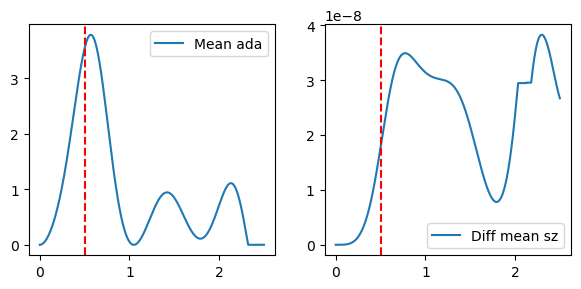

In [149]:
end = -1
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(mean4.tlist[:end], n_ada[:end], label='Mean ada')
#ax[0].plot(tlist, piq_out.expect[1], label='PIQS ada')

ax[1].plot(mean4.tlist, np.real(n_sz[:,1]-n_sz[:,0]), label='Diff mean sz')
#ax[1].plot(tlist, piq_out.expect[0], label='PIQS sz')

ax[0].axvline(x=0.5,color='red', linestyle='--')
ax[0].legend()
ax[1].axvline(x=0.5,color='red', linestyle='--')
ax[1].legend()

In [141]:
n_sz[:,1]-n_sz[:,0]

array([0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j, ...,
       2.67488931e-08+0.j, 2.67284935e-08+0.j, 2.67082339e-08+0.j])

In [6]:
def plot_heat(x, y, z_min, z_max, z):
    # x,y: x and y axis variables
    # z: dependent variable, dimension dim(x)*dim(y)
    # z_min, z_max: range of z to plot
    c = plt.pcolormesh(x, y, z, cmap = 'CMRmap', vmin = z_min, vmax = z_max)
    plt.colorbar(c)

## Mean-field equations (one spin class)

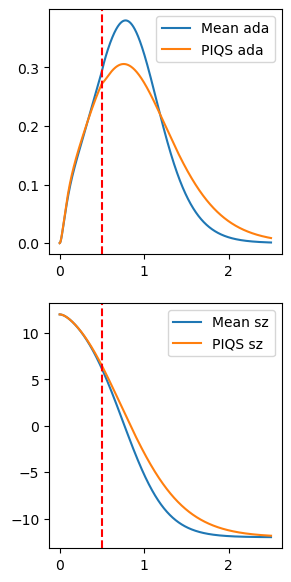

In [235]:
end = -1
fig, ax = plt.subplots(2,1, figsize=(3,7))

ax[0].plot(mean3.tlist[:end], n_ada[:end], label='Mean ada')
ax[0].plot(tlist, piq_out.expect[1], label='PIQS ada')

ax[1].plot(mean3.tlist[:end], np.real(n_sz[:end])*mean3.N_class, label='Mean sz')
ax[1].plot(tlist, piq_out.expect[0], label='PIQS sz')

ax[0].axvline(x=0.5,color='red', linestyle='--')
ax[0].legend()
ax[1].axvline(x=0.5,color='red', linestyle='--')
ax[1].legend()